### 1.按公司文件分开训练模型

GPU 可用，使用 GPU 加速
Epoch 1/100, Validation Loss: 0.263773113489151
Epoch 2/100, Validation Loss: 0.10615045949816704
Epoch 3/100, Validation Loss: 0.00823951605707407
Epoch 4/100, Validation Loss: 0.0081213996745646
Epoch 5/100, Validation Loss: 0.024872006848454475
Epoch 6/100, Validation Loss: 0.029411382041871548
Epoch 7/100, Validation Loss: 0.020498706959187984
Epoch 8/100, Validation Loss: 0.011245330097153783
Epoch 9/100, Validation Loss: 0.007108432240784168
Epoch 10/100, Validation Loss: 0.009028170257806778
Epoch 11/100, Validation Loss: 0.009898706804960966
Epoch 12/100, Validation Loss: 0.009209127631038427
Epoch 13/100, Validation Loss: 0.0068113047163933516
Epoch 14/100, Validation Loss: 0.0056314715184271336
Epoch 15/100, Validation Loss: 0.0063446632120758295
Epoch 16/100, Validation Loss: 0.005417963839136064
Epoch 17/100, Validation Loss: 0.006805634358897805
Epoch 18/100, Validation Loss: 0.004964695428498089
Epoch 19/100, Validation Loss: 0.004509677411988378
Epoch 20

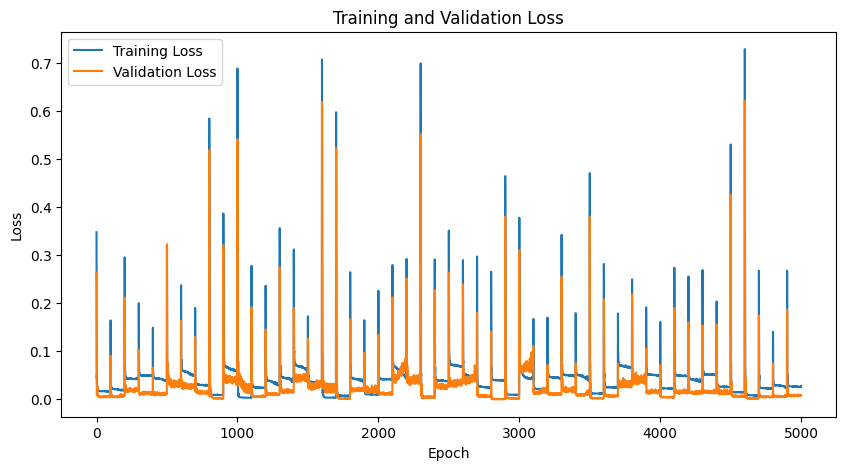

000001.SZ_平安银行_all2.xlsx: MAE=0.04729313775897026, MSE=0.004990675486624241, R2=-0.00483501493528915
000002.SZ_万科A_all2.xlsx: MAE=0.49782299995422363, MSE=0.2851705253124237, R2=-4.492720497071368
000063.SZ_中兴通讯_all2.xlsx: MAE=0.07778528332710266, MSE=0.008900240063667297, R2=-0.0023216487722406143
000100.SZ_TCL科技_all2.xlsx: MAE=0.09433439373970032, MSE=0.017948618158698082, R2=0.009685071517129829
000157.SZ_中联重科_all2.xlsx: MAE=0.08865263313055038, MSE=0.016953270882368088, R2=0.012645960299696668
000166.SZ_申万宏源_all2.xlsx: MAE=0.10665073245763779, MSE=0.020601360127329826, R2=-0.22987220098642736
000301.SZ_东方盛虹_all2.xlsx: MAE=0.12928985059261322, MSE=0.024037769064307213, R2=-0.4965115153845234
000333.SZ_美的集团_all2.xlsx: MAE=0.1110888123512268, MSE=0.021714257076382637, R2=-0.1329971833109107
000338.SZ_潍柴动力_all2.xlsx: MAE=0.026429546996951103, MSE=0.0012401217827573419, R2=-0.1812632570256072
000408.SZ_藏格矿业_all2.xlsx: MAE=0.3033112585544586, MSE=0.12035471200942993, R2=-6.52415767364278

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """
    # 假设我们想要跳过名为'所属申万行业名称(2014)_[行业级别]一级行业'和'股票收益率1'的列
    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    x = data.iloc[:, 3:11].values
    y = data.iloc[:, -5].values
    # 数据标准化
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled


def train_and_evaluate_model(model, train_loader, val_loader, test_loader, num_epochs, learning_rate, device):
    """
    训练和评估模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param test_loader: 测试数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表，测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return train_losses, val_losses, mae, mse, r2


def main():
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = 10
    num_epochs = 100
    learning_rate = 0.001
    input_size = 8  # 因为 x 是 data.iloc[:, 3:11].values
    hidden_size = 50
    num_layers = 2
    output_size = 1


    # 检查设备
    if torch.cuda.is_available():
        device = torch.device("cuda:0")  # 使用第一个 GPU
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")


    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []


    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size]
            val_y = sequences_y[train_size:train_size + val_size]
            test_x = sequences_x[train_size + val_size:]
            test_y = sequences_y[train_size + val_size:]
            train_dataset = TensorDataset(train_x, train_y)
            val_dataset = TensorDataset(val_x, val_y)
            test_dataset = TensorDataset(test_x, test_y)
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=32)
            model = BiLSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
            train_losses, val_losses, mae, mse, r2 = train_and_evaluate_model(model, train_loader, val_loader, test_loader, num_epochs, learning_rate, device)
            all_train_losses.extend(train_losses)
            all_val_losses.extend(val_losses)
            all_mae.append(mae)
            all_mse.append(mse)
            all_r2.append(r2)


    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(all_train_losses, label='Training Loss')
    plt.plot(all_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()


    # 输出每个公司的指标结果
    for i, file in enumerate(os.listdir(folder_path)):
        if file.endswith('.xlsx'):
            print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')


class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTMModel, self).__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)


    def forward(self, x):
        out, _ = self.bilstm(x)
        out = self.fc(out[:, -1, :])
        return out


if __name__ == "__main__":
    main()

### 2.合在一块训练

GPU 可用，使用 GPU 加速
Epoch 1/600, Validation Loss: 0.028737366920940473
Epoch 2/600, Validation Loss: 0.02667079072340693
Epoch 3/600, Validation Loss: 0.027089064114425385
Epoch 4/600, Validation Loss: 0.02557509534165893
Epoch 5/600, Validation Loss: 0.023370596816317295
Epoch 6/600, Validation Loss: 0.023648284506839767
Epoch 7/600, Validation Loss: 0.023443439883560364
Epoch 8/600, Validation Loss: 0.023811607005100856
Epoch 9/600, Validation Loss: 0.02218616520985961
Epoch 10/600, Validation Loss: 0.023451818625482037
Epoch 11/600, Validation Loss: 0.02405694613731663
Epoch 12/600, Validation Loss: 0.022150690785386194
Epoch 13/600, Validation Loss: 0.022115283435813978
Epoch 14/600, Validation Loss: 0.022025803812372853
Epoch 15/600, Validation Loss: 0.02408924328924065
Epoch 16/600, Validation Loss: 0.02103480015238616
Epoch 17/600, Validation Loss: 0.023469278733180443
Epoch 18/600, Validation Loss: 0.027425041343544572
Epoch 19/600, Validation Loss: 0.02135322514501676
Epoch 20/60

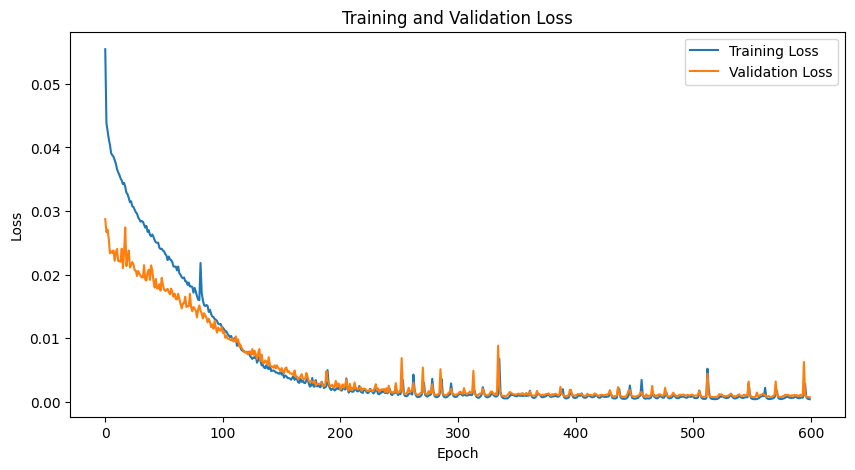

000001.SZ_平安银行_all2.xlsx: MAE=0.11622500419616699, MSE=0.02126527763903141, R2=-3.281603792706864
000002.SZ_万科A_all2.xlsx: MAE=0.20760013163089752, MSE=0.07144663482904434, R2=-0.3761464213136685
000063.SZ_中兴通讯_all2.xlsx: MAE=0.09801862388849258, MSE=0.014899731613695621, R2=-0.6779685674858222
000100.SZ_TCL科技_all2.xlsx: MAE=0.1464707851409912, MSE=0.02949327975511551, R2=-0.6272915848481369
000157.SZ_中联重科_all2.xlsx: MAE=0.1389782875776291, MSE=0.04091634228825569, R2=-1.382957100023932
000166.SZ_申万宏源_all2.xlsx: MAE=0.12456899881362915, MSE=0.02724960446357727, R2=-0.6267630289623036
000301.SZ_东方盛虹_all2.xlsx: MAE=0.13517555594444275, MSE=0.03059828281402588, R2=-0.9049472605901445
000333.SZ_美的集团_all2.xlsx: MAE=0.15893150866031647, MSE=0.03990812599658966, R2=-1.082308933187035
000338.SZ_潍柴动力_all2.xlsx: MAE=0.1613205522298813, MSE=0.036843717098236084, R2=-34.09504606527795
000408.SZ_藏格矿业_all2.xlsx: MAE=0.10062488168478012, MSE=0.02576535940170288, R2=-0.610760625411257
000425.SZ_徐工机械_a

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


def create_sequences(input_data, target_data, seq_length):
    """
    创建时间序列数据窗口
    :param input_data: 输入数据
    :param target_data: 目标数据
    :param seq_length: 时间序列长度
    :return: 序列输入和序列目标
    """
    sequences_x = []
    sequences_y = []
    for i in range(len(input_data) - seq_length):
        sequences_x.append(input_data[i:i + seq_length])
        sequences_y.append(target_data[i + seq_length])
    return np.array(sequences_x), np.array(sequences_y)


def load_and_preprocess_data(file_path):
    """
    加载并预处理数据
    :param file_path: 文件路径
    :return: 预处理后的序列数据
    """
    # 假设我们想要跳过名为'所属申万行业名称(2014)_[行业级别]一级行业'和'股票收益率1'的列
    skip_column_names = ['所属申万行业名称(2014)_[行业级别]一级行业', '股票收益率1']
    all_columns = pd.read_excel(file_path, nrows=0).columns
    columns_to_use = [col for col in all_columns if col not in skip_column_names]
    data = pd.read_excel(file_path, usecols=columns_to_use)
    data = data.iloc[7:, 1:]
    x = data.iloc[:, 3:11].values
    y = data.iloc[:, -5].values
    # 数据标准化
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    x_scaled = scaler_x.fit_transform(x)
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))
    return x_scaled, y_scaled


def train_model(model, train_loader, val_loader, num_epochs, learning_rate, device):
    """
    训练模型
    :param model: 模型
    :param train_loader: 训练数据加载器
    :param val_loader: 验证数据加载器
    :param num_epochs: 训练轮数
    :param learning_rate: 学习率
    :param device: 运行设备
    :return: 训练损失列表，验证损失列表
    """
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    val_losses = []
    # 将训练集和验证集数据合并
    all_train_data = ConcatDataset([train_loader.dataset, val_loader.dataset])
    all_train_loader = DataLoader(all_train_data, batch_size=32, shuffle=True)
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0
        for inputs, targets in all_train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        train_losses.append(epoch_train_loss / len(all_train_loader))
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss / len(val_loader)}')
    return train_losses, val_losses


def evaluate_model(model, test_loader, device):
    """
    评估模型
    :param model: 模型
    :param test_loader: 测试数据加载器
    :param device: 运行设备
    :return: 测试集上的 MAE, MSE, R2 指标
    """
    criterion = nn.MSELoss()
    model.eval()
    test_loss = 0
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()
            test_predictions.extend(outputs.cpu().numpy().flatten())
            test_targets.extend(targets.cpu().numpy().flatten())
    test_loss /= len(test_loader)
    mae = mean_absolute_error(test_targets, test_predictions)
    mse = mean_squared_error(test_targets, test_predictions)
    r2 = r2_score(test_targets, test_predictions)
    return mae, mse, r2


def main():
    folder_path = 'E:/2412毕业论文/0104数据特征/wind250109/0109沪深300股票1/处理2/处理'
    time_windows = 10
    num_epochs = 600
    learning_rate = 0.001
    input_size = 8  # 因为 x 是 data.iloc[:, 3:11].values
    hidden_size = 50
    num_layers = 2
    output_size = 1

    # 检查设备
    if torch.cuda.is_available():
        device = torch.device("cuda:0")  # 使用第一个 GPU
        print("GPU 可用，使用 GPU 加速")
    else:
        device = torch.device("cpu")
        print("GPU 不可用，使用 CPU")

    all_train_losses = []
    all_val_losses = []
    all_mae = []
    all_mse = []
    all_r2 = []

    # 存储所有公司的训练集、验证集和测试集数据
    all_train_x = []
    all_train_y = []
    all_val_x = []
    all_val_y = []
    all_test_x = []
    all_test_y = []

    file_list = []

    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_list.append(file)
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)  # 1.先读取文件
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows)  # 2.滑动窗口造样本
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            train_x = sequences_x[:train_size]
            train_y = sequences_y[:train_size]
            val_x = sequences_x[train_size:train_size + val_size]  # 针对时间窗口，尽可能使用所有数据序列
            val_y = sequences_y[train_size:train_size + val_size]
            # test_x = sequences_x[train_size + val_size:]
            # test_y = sequences_y[train_size + val_size:]
            all_train_x.append(train_x)
            all_train_y.append(train_y)
            all_val_x.append(val_x)
            all_val_y.append(val_y)
            # all_test_x.extend(test_x)#@修改为列表中的列表
            # all_test_y.extend(test_y)#@修改为列表中的列表

    # 合并所有公司的训练集和验证集数据
    train_x = torch.cat(all_train_x, dim=0)
    train_y = torch.cat(all_train_y, dim=0)
    val_x = torch.cat(all_val_x, dim=0)
    val_y = torch.cat(all_val_y, dim=0)

    train_dataset = TensorDataset(train_x, train_y)
    val_dataset = TensorDataset(val_x, val_y)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 3.混合样本
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

    model = BiLSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
    # 1.训练
    train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs, learning_rate, device)

    # 2.验证mae,mse
    for file in os.listdir(folder_path):
        if file.endswith('.xlsx'):
            file_path = os.path.join(folder_path, file)
            x_scaled, y_scaled = load_and_preprocess_data(file_path)
            sequences_x, sequences_y = create_sequences(x_scaled, y_scaled, time_windows) #滑动窗口
            sequences_x = torch.FloatTensor(sequences_x).to(device)
            sequences_y = torch.FloatTensor(sequences_y).to(device)
            train_size = int(0.7 * len(sequences_x))
            val_size = int(0.2 * len(sequences_x))
            test_size = len(sequences_x) - train_size - val_size
            test_x = sequences_x[train_size + val_size:]
            test_y = sequences_y[train_size + val_size:]
            test_dataset = TensorDataset(test_x, test_y)
            test_loader = DataLoader(test_dataset, batch_size=32)
            mae, mse, r2 = evaluate_model(model, test_loader, device)
            all_mae.append(mae)
            all_mse.append(mse)
            all_r2.append(r2)

    all_train_losses.extend(train_losses)
    all_val_losses.extend(val_losses)

    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(all_train_losses, label='Training Loss')
    plt.plot(all_val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    # 输出每个公司的指标结果
    for i, file in enumerate(file_list):
        print(f'{file}: MAE={all_mae[i]}, MSE={all_mse[i]}, R2={all_r2[i]}')

    # 存储模型
    model_save_path = 'best_lstm_model.pth'
    torch.save(model.state_dict(), model_save_path)
    print(f"模型已存储在 {model_save_path}")


class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTMModel, self).__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)


    def forward(self, x):
        out, _ = self.bilstm(x)
        out = self.fc(out[:, -1, :])
        return out

if __name__ == "__main__":
    main()